## K-Means Station Clustering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

from deepar_model_utils import prep_station_data
from deepar_model_utils import get_station_data
from deepar_model_utils import deepar_station_data
from deepar_model_utils import write_dicts_to_file

%matplotlib inline

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
s3_bucket = ""

## Trip Start Station

In [2]:
#start_file = "s3://{}/model_trips_start_station_20208029_20220831.csv".format(s3_bucket)

start_file = "../model_trips_start_station_20208029_20220831.csv"

trips_start = pd.read_csv(start_file, parse_dates = True)
trips_start.shape

(6059710, 2)

In [3]:
trips_start_all_group = prep_station_data(trips_start, "start station id", "starttime")
print(sum(trips_start_all_group["size"]))

6059710


In [4]:
freq = "D" # group and sum trips by a set increment
min_date = "2020-08-29 00:00:00" # make sure all series end at the same time
max_date = "2022-08-31 23:45:00" # make sure all series end at the same time

**EDA**

In [ ]:
# from manual_station_clustering notebook
most_popular_start = [67, 68, 74, 60, 178, 46, 107, 179, 9, 53]
semi_popular_start = [157, 471, 40, 39, 437, 177, 190, 22, 386, 33]
least_popular_start = [546, 556, 543, 388, 548, 317, 571, 308, 570, 572]

In [ ]:
fig, axs = plt.subplots(10, 1, figsize = (20, 20), sharex = True)
axx = axs.ravel()
for i in range(0, 10):
    temp_station = least_popular_start[i]
    get_station_data(trips_start_all_group, "start station id", "starttime", temp_station, freq, max_date, cluster = True, min_date = min_date).plot(ax = axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("trip count")
    axx[i].set_title(str(temp_station))
    axx[i].grid(which = "minor", axis = "x")

**Time Series K-Means Clustering**

In [5]:
start_list = []
for station in tqdm(trips_start_all_group["start station id"].unique()):
    start_station_data = get_station_data(trips_start_all_group, "start station id", "starttime", station, freq, max_date, cluster = True, min_date = min_date)
    start_list.append(start_station_data["size"].tolist())

100%|██████████| 451/451 [00:13<00:00, 32.42it/s]


In [6]:
print(len(start_list))
print(sum([sum(i) for i in zip(*start_list)]))

451
6059710


In [7]:
formatted_start_list = to_time_series_dataset(start_list)
formatted_start_list.shape

(451, 733, 1)

In [ ]:
cluster_count = 21

In [ ]:
%%time # 21 mins 31 secs
start_km = TimeSeriesKMeans(n_clusters = cluster_count, metric = "dtw", max_iter = 10)
start_km_labels = start_km.fit_predict(formatted_start_list)

CPU times: user 20min 7s, sys: 3min 32s, total: 23min 39s
Wall time: 21min 31s


In [11]:
start_series_names = [station for station in trips_start_all_group["start station id"].unique()]
start_km_labels_list = [label for label in start_km_labels]

start_clusters = pd.DataFrame(zip(start_series_names, start_km_labels_list), columns = ["station id", "cluster"]).sort_values(by = "cluster")
start_clusters

,station id,cluster
450,571,0
130,389,0
329,348,0
328,1,0
327,355,0
...,...,...
41,380,20
74,41,20
2,81,20
64,80,20


In [12]:
start_clusters.to_csv("start_clusters.csv", index = False)

**Cluster Analysis**

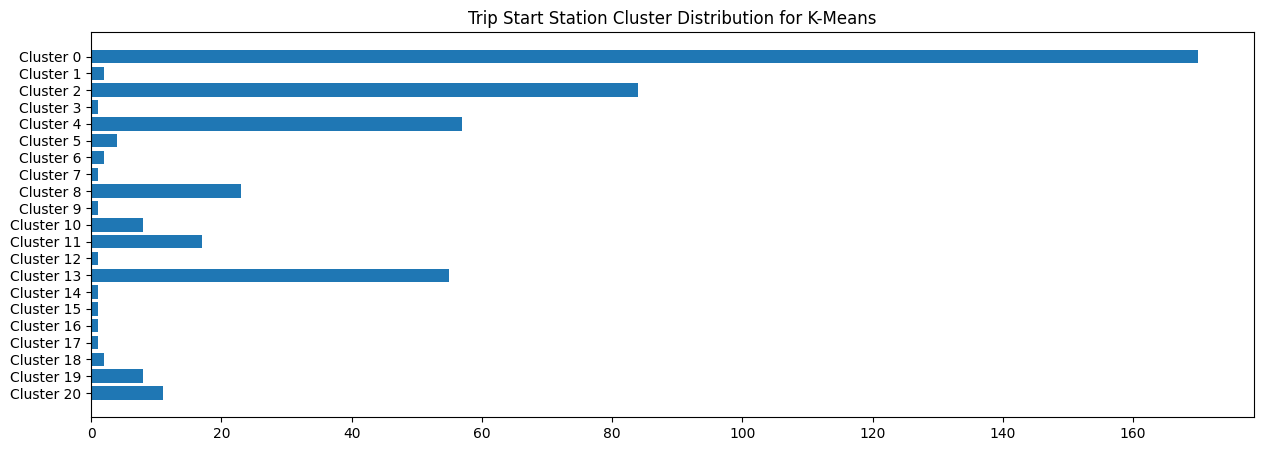

In [27]:
start_cluster_c = [len(start_km_labels[start_km_labels == i]) for i in range(cluster_count)]
start_cluster_n = ["Cluster " + str(i) for i in range(cluster_count)]
plt.figure(figsize = (15, 5))
plt.title("Trip Start Station Cluster Distribution for K-Means")
plt.barh(start_cluster_n, start_cluster_c)
plt.gca().invert_yaxis()
plt.show()

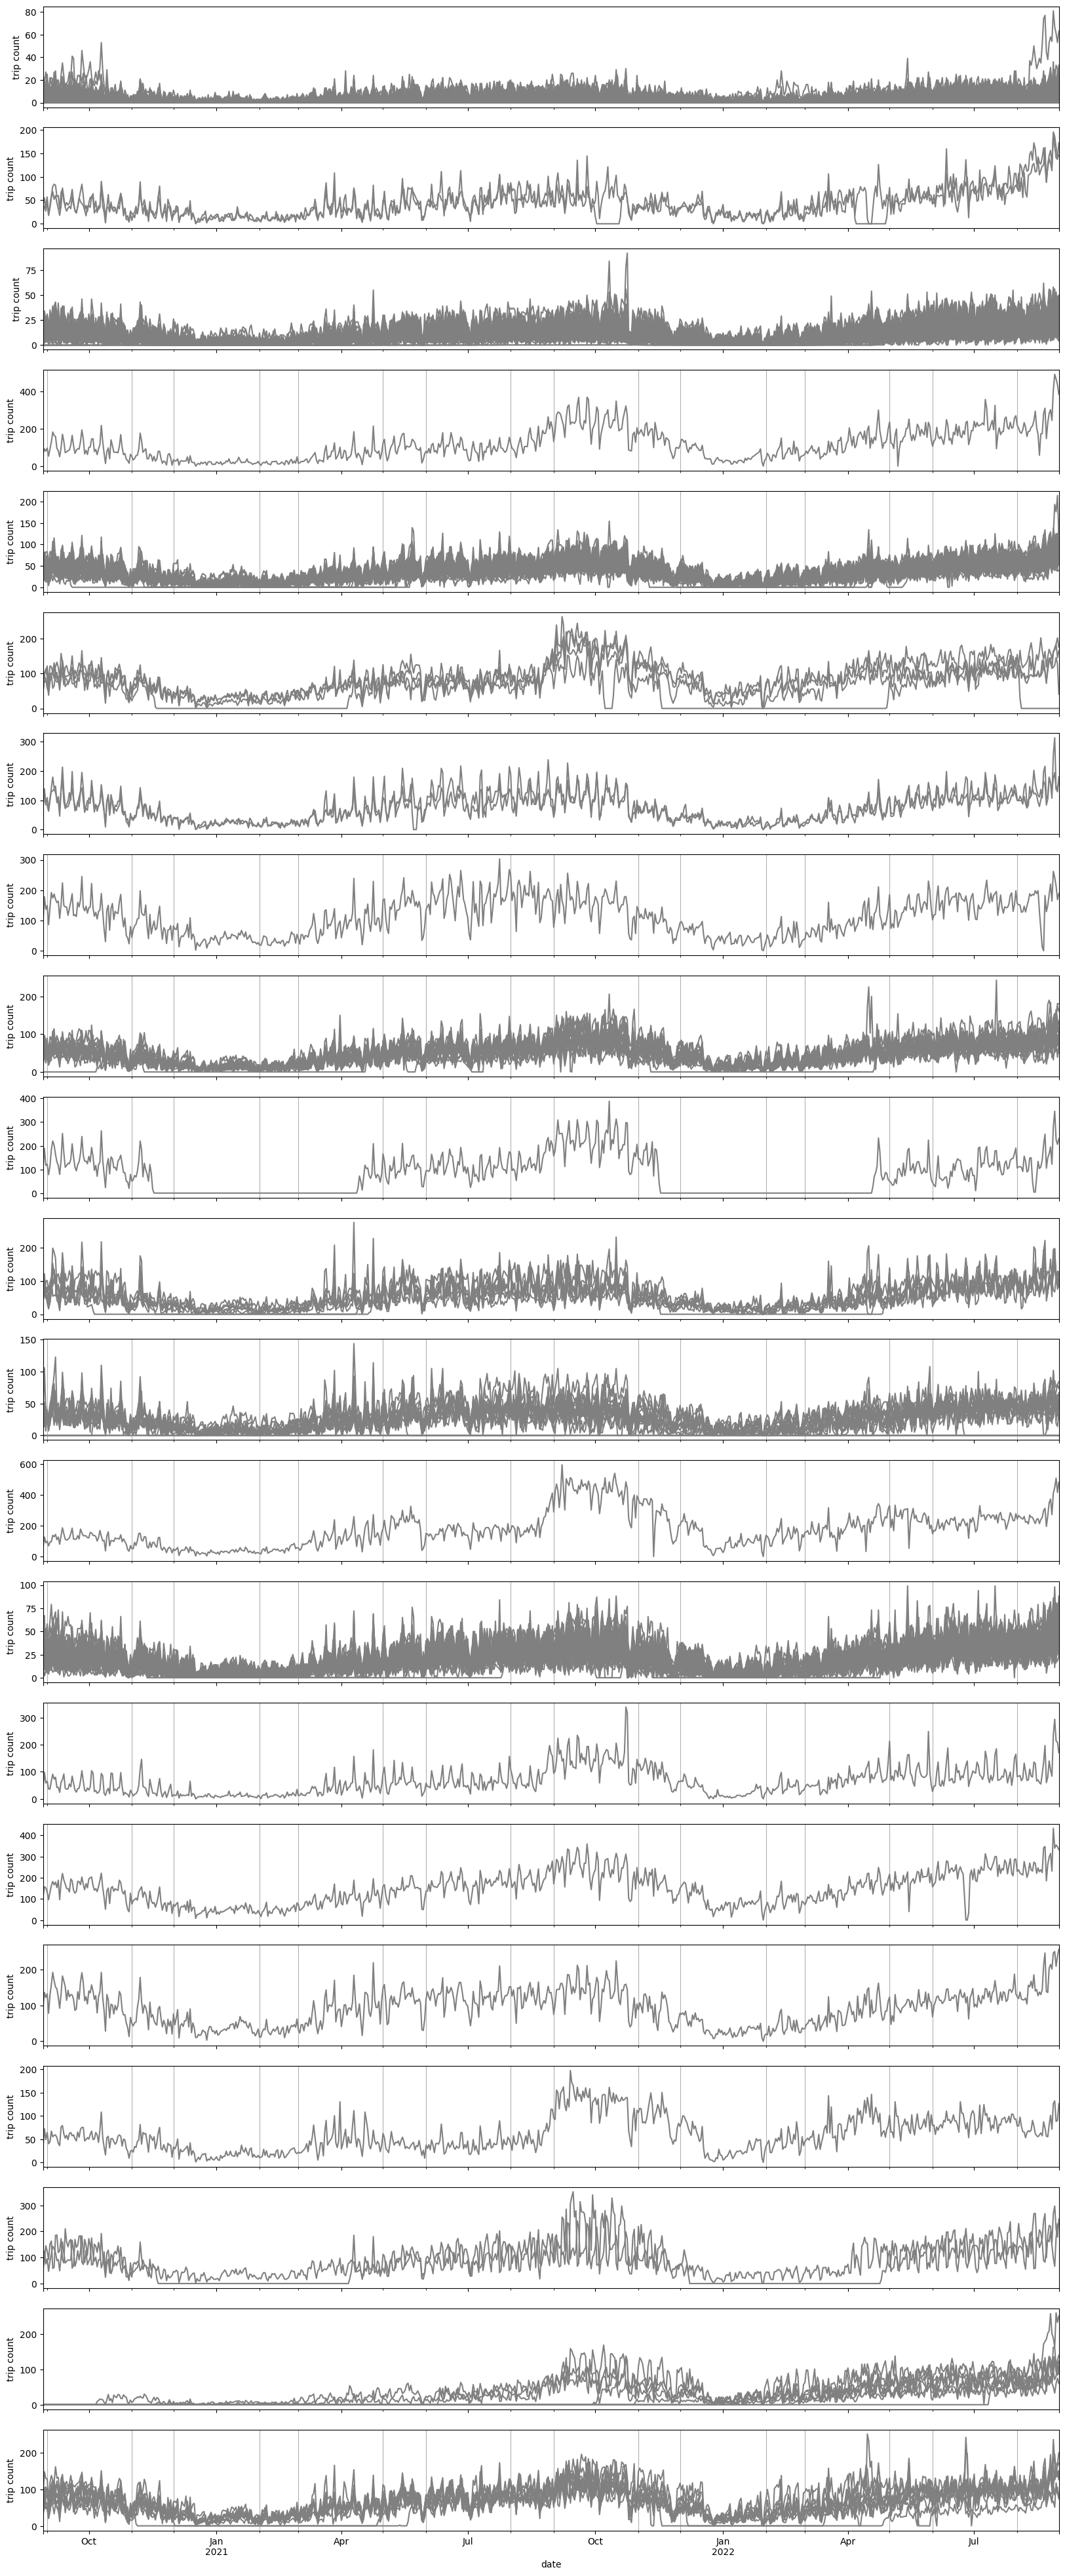

In [29]:
fig, axs = plt.subplots(cluster_count, 1, figsize = (20, 50), sharex = True)
axx = axs.ravel()
for i in range(0, cluster_count):
    start_cluster = start_clusters[start_clusters["cluster"] == i]
    for j in range(len(start_cluster)):
        temp_station = start_cluster.iloc[j]["station id"]
        get_station_data(trips_start_all_group, "start station id", "starttime", temp_station, freq, max_date, cluster = True, min_date = min_date).plot(ax = axx[i], color = "#808080")
        axx[i].set_xlabel("date")
        axx[i].set_ylabel("trip count")
        axx[i].set_title("Start Station Cluster " + str(i))
        axx[i].grid(which = "minor", axis = "x")
        axx[i].get_legend().remove()

## Trip End Station

In [2]:
#stop_file = "s3://{}/model_trips_stop_station_20208029_20220831.csv".format(s3_bucket)

stop_file = "../model_trips_stop_station_20208029_20220831.csv"

trips_stop = pd.read_csv(stop_file, parse_dates = True)
trips_stop.shape

(6059354, 2)

In [3]:
trips_stop_all_group = prep_station_data(trips_stop, "end station id", "stoptime")
print(sum(trips_stop_all_group["size"]))

6059354


In [4]:
freq = "D" # group and sum trips by a set increment
min_date = "2020-08-29 00:00:00" # make sure all series end at the same time
max_date = "2022-08-31 23:45:00" # make sure all series end at the same time

**EDA**

In [ ]:
# from manual_station_clustering notebook
most_popular_stop = [67, 68, 74, 60, 107, 46, 178, 179, 53, 9]
semi_popular_stop = [189, 471, 39, 40, 437, 190, 370, 22, 33, 459]
least_popular_stop = [556, 543, 388, 548, 317, 308, 570, 572, 571, 438]

In [ ]:
fig, axs = plt.subplots(10, 1, figsize = (20, 20), sharex = True)
axx = axs.ravel()
for i in range(0, 10):
    temp_station = least_popular_stop[i]
    get_station_data(trips_stop_all_group, "end station id", "stoptime", temp_station, freq, max_date, cluster = True, min_date = min_date).plot(ax = axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("trip count")
    axx[i].set_title(str(temp_station))
    axx[i].grid(which = "minor", axis = "x")

**Time Series K-Means Clustering**

In [5]:
stop_list = []
for station in tqdm(trips_stop_all_group["end station id"].unique()):
    stop_station_data = get_station_data(trips_stop_all_group, "end station id", "stoptime", station, freq, max_date, cluster = True, min_date = min_date)
    stop_list.append(stop_station_data["size"].tolist())

100%|██████████| 452/452 [00:19<00:00, 22.76it/s]


In [6]:
print(len(stop_list))
print(sum([sum(i) for i in zip(*stop_list)]))

452
6059354


In [7]:
formatted_stop_list = to_time_series_dataset(stop_list)
formatted_stop_list.shape

(452, 733, 1)

In [ ]:
cluster_count = 21

In [8]:
%%time # 20 mins 52 secs
stop_km = TimeSeriesKMeans(n_clusters = cluster_count, metric = "dtw", max_iter = 10)
stop_km_labels = stop_km.fit_predict(formatted_stop_list)

CPU times: user 19min 8s, sys: 3min 26s, total: 22min 34s
Wall time: 20min 52s


In [11]:
stop_series_names = [station for station in trips_stop_all_group["end station id"].unique()]
stop_km_labels_list = [label for label in stop_km_labels]

stop_clusters = pd.DataFrame(zip(stop_series_names, stop_km_labels_list), columns = ["station id", "cluster"]).sort_values(by = "cluster")
stop_clusters

,station id,cluster
0,99,0
234,159,0
370,488,0
404,523,0
239,137,0
...,...,...
151,97,20
84,75,20
88,459,20
129,55,20


In [12]:
stop_clusters.to_csv("stop_clusters.csv", index = False)

**Cluster Analysis**

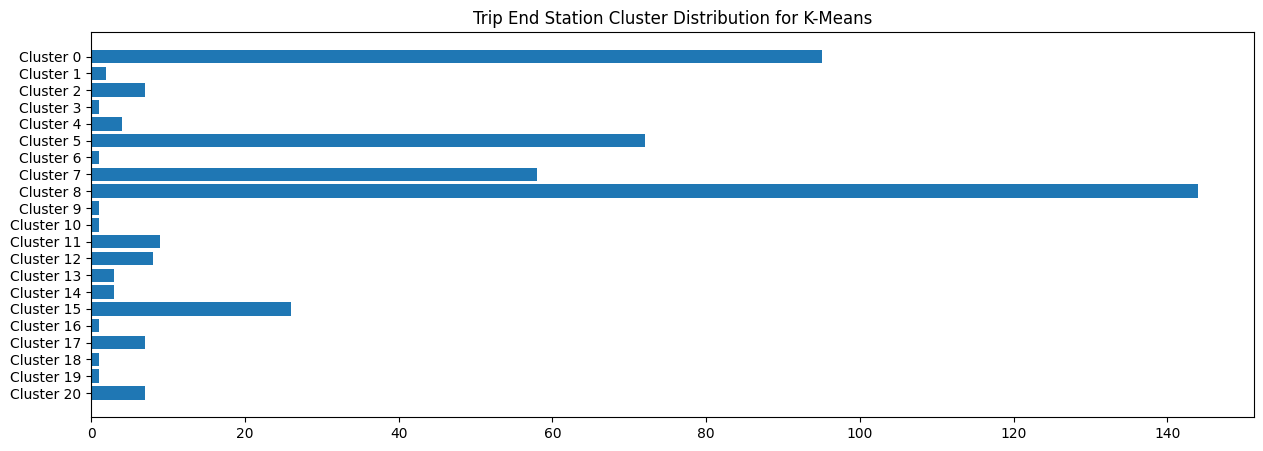

In [13]:
stop_cluster_c = [len(stop_km_labels[stop_km_labels == i]) for i in range(cluster_count)]
stop_cluster_n = ["Cluster " + str(i) for i in range(cluster_count)]
plt.figure(figsize = (15, 5))
plt.title("Trip End Station Cluster Distribution for K-Means")
plt.barh(stop_cluster_n, stop_cluster_c)
plt.gca().invert_yaxis()
plt.show()

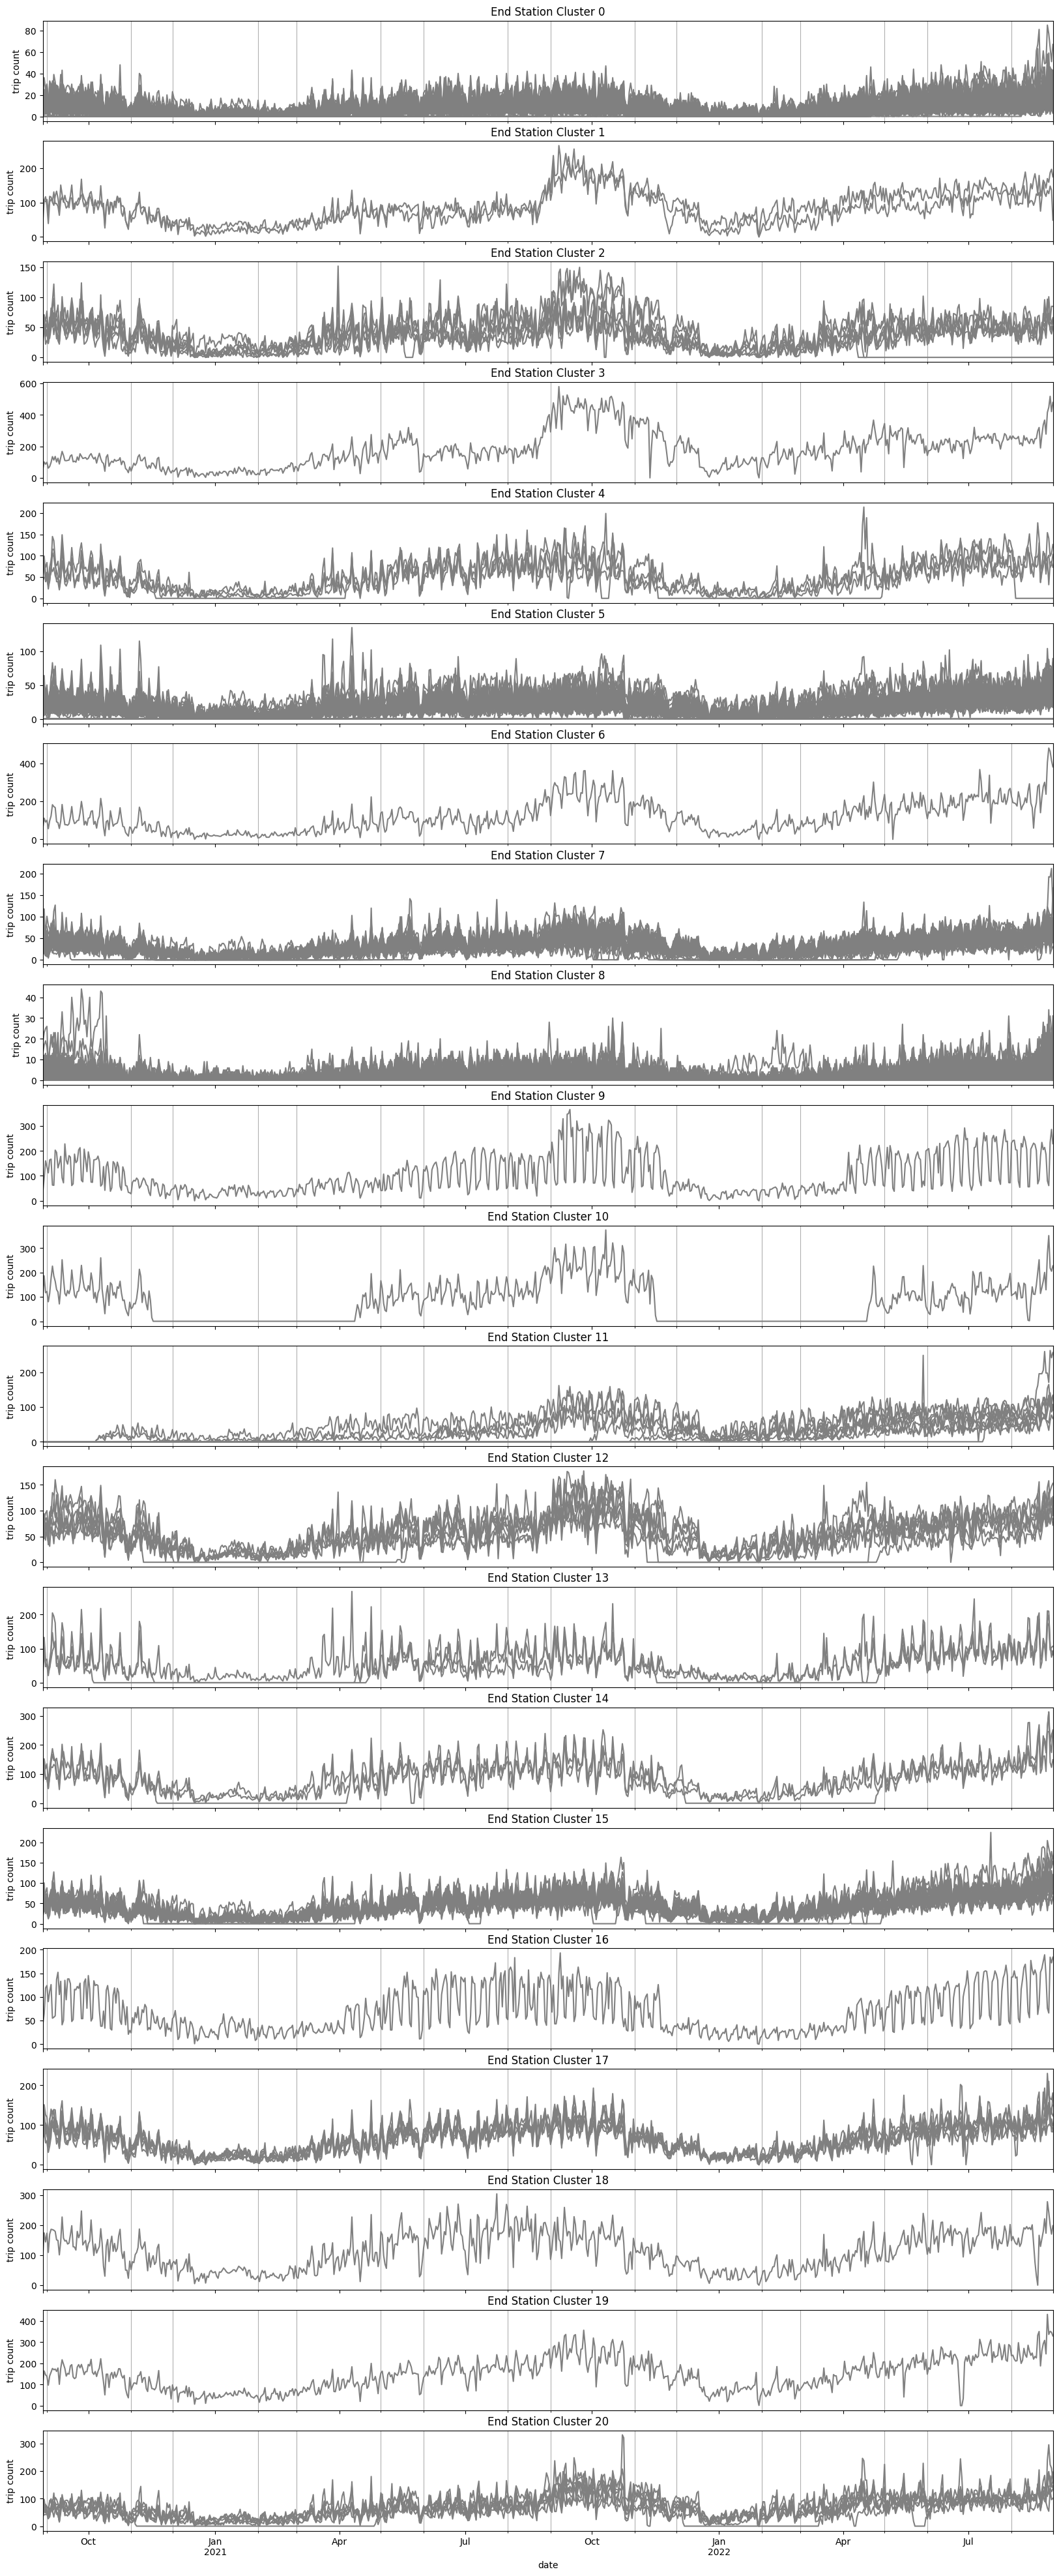

In [14]:
fig, axs = plt.subplots(cluster_count, 1, figsize = (20, 50), sharex = True)
axx = axs.ravel()
for i in range(0, cluster_count):
    stop_cluster = stop_clusters[stop_clusters["cluster"] == i]
    for j in range(len(stop_cluster)):
        temp_station = stop_cluster.iloc[j]["station id"]
        get_station_data(trips_stop_all_group, "end station id", "stoptime", temp_station, freq, max_date, cluster = True, min_date = min_date).plot(ax = axx[i], color = "#808080")
        axx[i].set_xlabel("date")
        axx[i].set_ylabel("trip count")
        axx[i].set_title("End Station Cluster " + str(i))
        axx[i].grid(which = "minor", axis = "x")
        axx[i].get_legend().remove()